In [515]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import colors
import cv2
from ultralytics import YOLO
from IPython.display import display
from PIL import Image, ImageDraw
from sklearn.cluster import DBSCAN
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform

### Load ply, cut in half, and visualize

In [516]:
data_folder = "./example_001/"
# data_folder = "./tmp4/"
pcd_file = "fused.ply"

pcd = o3d.io.read_point_cloud(data_folder+pcd_file)
points = np.asarray(pcd.points)


In [517]:
min_y = np.min(points[:, 1])
max_y = np.max(points[:, 1])
mid_way = (min_y + max_y) / 2

print(f"Min Y: {min_y}")
print(f"Max Y: {max_y}")
print(f"Mid Way: {mid_way}")

Min Y: -2.757521629333496
Max Y: 0.9876130819320679
Mid Way: -0.8849542737007141


In [518]:
# Create mask for points below mid_way height
below_mid_mask = points[:, 1] > mid_way

# Filter points
below_mid_points = points[below_mid_mask]

# Create new point cloud with filtered points
below_mid_pcd = o3d.geometry.PointCloud()
below_mid_pcd.points = o3d.utility.Vector3dVector(below_mid_points)
below_mid_pcd.voxel_down_sample(voxel_size=0.09)

# Visualize the lower half of the point cloud
# o3d.visualization.draw_geometries([below_mid_pcd], window_name="Points Below Midway")

PointCloud with 21535 points.

### Extract x, z points and create grid density histogram

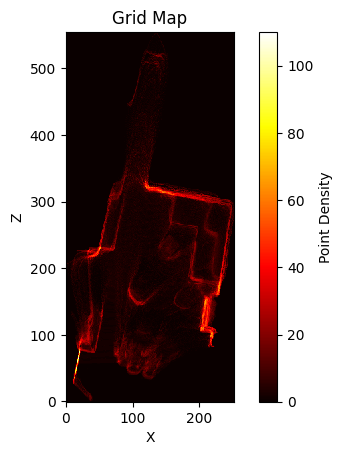

In [519]:
grid_resolution = 0.02

x_indices = np.floor(below_mid_points[:, 0] / grid_resolution).astype(int)
z_indices = np.floor(below_mid_points[:, 2] / grid_resolution).astype(int)

x_min, z_min = x_indices.min(), z_indices.min()
x_indices -= x_min
z_indices -= z_min

# empty grid
grid_shape = (x_indices.max() + 1, z_indices.max() + 1)
grid = np.zeros(grid_shape, dtype=int)


for x, z in zip(x_indices, z_indices):
    grid[x, z] += 1

plt.imshow(grid.T, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Point Density')
plt.title('Grid Map')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()


### Load camera poses, add to plot, visualize

In [520]:
camera_folder = data_folder + "camera"

npz_files = glob.glob(os.path.join(camera_folder, "*.npz"))
sorted_npz_files = sorted(npz_files)

# Load each npz file
npz_data = []
cam_positions = []

for npz_file in sorted_npz_files:
    data = np.load(npz_file)
    npz_data.append(data)
    cam_positions.append(data["pose"][:3, 3])
    print(f"Loaded {os.path.basename(npz_file)}")
    
cam_positions = np.array(cam_positions)


Loaded 000000.npz
Loaded 000001.npz
Loaded 000002.npz
Loaded 000003.npz
Loaded 000004.npz
Loaded 000005.npz
Loaded 000006.npz
Loaded 000007.npz
Loaded 000008.npz
Loaded 000009.npz
Loaded 000010.npz
Loaded 000011.npz
Loaded 000012.npz


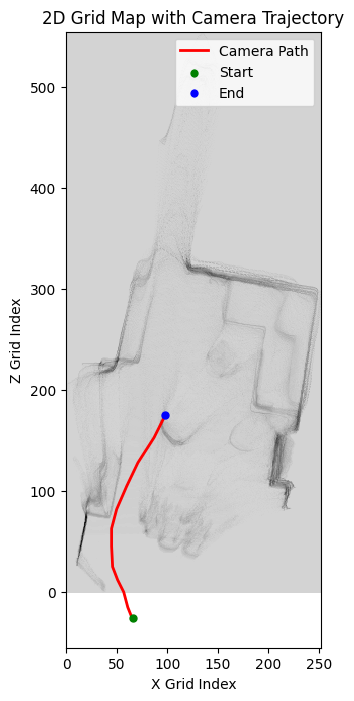

In [521]:
cam_x = np.floor(cam_positions[:, 0] / grid_resolution).astype(int) - x_min
cam_z = np.floor(cam_positions[:, 2] / grid_resolution).astype(int) - z_min

# this changes colors to gray
norm = colors.Normalize(vmin=0, vmax=np.max(grid))
cmap = colors.LinearSegmentedColormap.from_list('gray_to_black', ['#D3D3D3', 'black'])

plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()


### Run Obj Detection for Annotations

In [522]:
model = YOLO("yolo11n.pt")

In [523]:
colors = [(255, 87, 51), (51, 255, 87), (51, 87, 255), (255, 51, 161), (161, 51, 255), (51, 255, 241), (241, 255, 51), (255, 140, 51), (51, 168, 255), (168, 255, 51), (255, 51, 51), (51, 255, 140), (140, 51, 255), (255, 51, 241), (241, 51, 255), (51, 255, 178), (178, 51, 255), (255, 178, 51), (51, 212, 255), (212, 255, 51), (255, 51, 102), (102, 51, 255), (51, 255, 102), (255, 102, 51), (51, 102, 255), (102, 255, 51), (255, 51, 204), (204, 51, 255), (51, 255, 204), (204, 255, 51), (255, 153, 51), (153, 51, 255), (51, 255, 153), (153, 255, 51), (255, 51, 51), (51, 255, 255), (255, 255, 51), (255, 51, 255), (51, 51, 255), (255, 170, 51), (170, 51, 255), (51, 255, 170), (170, 255, 51), (255, 68, 170), (68, 170, 255), (170, 255, 68), (255, 85, 170), (85, 170, 255), (170, 255, 85), (255, 102, 170), (102, 170, 255), (170, 255, 102), (255, 119, 170), (119, 170, 255), (170, 255, 119), (255, 136, 170), (136, 170, 255), (170, 255, 136), (255, 153, 170), (153, 170, 255), (170, 255, 153), (255, 170, 153), (170, 153, 255), (153, 255, 170), (255, 170, 187), (170, 187, 255), (187, 255, 170), (255, 187, 170), (187, 170, 255), (170, 255, 187), (255, 204, 170), (204, 170, 255), (170, 255, 204), (255, 221, 170), (221, 170, 255), (170, 255, 221), (255, 238, 170), (238, 170, 255), (170, 255, 238), (255, 255, 255)]

In [524]:
frames_folder = data_folder + "color"

jpg_files = glob.glob(os.path.join(frames_folder, "*.png"))
sorted_jpg_files = sorted(jpg_files)

In [525]:
def images_to_video(image_paths, output_path, fps=30):
    if not image_paths:
        raise ValueError("No images provided.")

    # Read the first image to get dimensions
    first_image = cv2.imread(image_paths[0])
    height, width, _ = first_image.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Skipping unreadable image: {path}")
            continue
        # Resize if necessary to match dimensions
        if img.shape[:2] != (height, width):
            img = cv2.resize(img, (width, height))
        out.write(img)

    out.release()
    print(f"Video saved to {output_path}")

In [526]:
video_path = data_folder + "video.mp4"
images_to_video(sorted_jpg_files, video_path, 30)
results = model.track(video_path, show=False, stream=True, tracker="botsort.yaml")

Video saved to ./example_001/video.mp4


In [527]:
data_by_frame = {}
for frame_i, r in enumerate(results):
  ids = r.boxes.id.tolist() if r.boxes.id is not None else []
  xyxy = r.boxes.xyxy.tolist() if r.boxes.xyxy is not None else []
  names = [r.names[cls.item()] for cls in r.boxes.cls.int()]
  confs = r.boxes.conf.tolist() if r.boxes.conf is not None else []
  
  data_by_frame[frame_i] = {
      "ids": ids,
      "xyxy": xyxy,
      "names": names,
      "confs": confs
  }
    
  print(f"Frame {frame_i}:")
  print(f"Ids: {ids}")
  print(f"Class Names: {names}")
  print(f"Confidence Scores: {confs}")
  print(f"Bounding Box: {xyxy}")
  print("\n")


video 1/1 (frame 1/13) /Users/kushkhanna/Documents/GitHub/solo-3d/ply_to_2d_map/example_001/video.mp4: 384x640 6 chairs, 8 potted plants, 3 dining tables, 43.3ms
Frame 0:
Ids: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
Class Names: ['chair', 'chair', 'chair', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'chair', 'dining table', 'potted plant', 'chair', 'chair', 'dining table', 'dining table']
Confidence Scores: [0.8532829284667969, 0.8504526615142822, 0.8038653135299683, 0.7011400461196899, 0.6228978037834167, 0.5936113595962524, 0.5456479787826538, 0.5084297060966492, 0.47435009479522705, 0.4633482098579407, 0.4573666751384735, 0.39805078506469727, 0.3587009012699127, 0.3135896325111389, 0.2917376756668091, 0.2739388346672058, 0.2647434175014496]
Bounding Box: [[328.260986328125, 174.55218505859375, 430.22723388671875, 287.39361572265625], [267.27606201171875, 153.869

In [528]:
data_by_id = {}

for frame_i, data in data_by_frame.items():
    ids = data['ids']
    names = data['names']
    confs = data['confs']
    xyxy = data['xyxy']
    
    # For whatever reason some frames may be able to detect objects but no id is assigned so we will just skip over those frames for simplicity purpose rn
    if len(ids) == len(xyxy) == len(names) == len(confs):
        for id, name, conf, xyxy in zip(ids, names, confs, xyxy):
            if id not in data_by_id:
                data_by_id[id] = {
                    "frames": [],
                    "names": [],
                    "confs": [],
                    "xyxy": []
                }
            data_by_id[id]["frames"].append(frame_i)
            data_by_id[id]["names"].append(name)
            data_by_id[id]["confs"].append(conf)
            data_by_id[id]["xyxy"].append(xyxy)
            
        print(f"Frame {frame_i}:")
        print(f"Ids: {ids}")
        print(f"Class Names: {names}")
        print(f"Confidence Scores: {confs}")
        print(f"Bounding Box: {xyxy}")
        print("\n")

Frame 0:
Ids: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
Class Names: ['chair', 'chair', 'chair', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'chair', 'dining table', 'potted plant', 'chair', 'chair', 'dining table', 'dining table']
Confidence Scores: [0.8532829284667969, 0.8504526615142822, 0.8038653135299683, 0.7011400461196899, 0.6228978037834167, 0.5936113595962524, 0.5456479787826538, 0.5084297060966492, 0.47435009479522705, 0.4633482098579407, 0.4573666751384735, 0.39805078506469727, 0.3587009012699127, 0.3135896325111389, 0.2917376756668091, 0.2739388346672058, 0.2647434175014496]
Bounding Box: [145.69888305664062, 147.51300048828125, 239.56845092773438, 256.40887451171875]


Frame 1:
Ids: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
Class Names: ['chair', 'chair', 'chair', 'potted plant', 'potted plant', 'potted 

In [529]:

data_by_id_cleaned = {}

for id, data in data_by_id.items():
  frames = data['frames']
  names = data['names']
  confs = data['confs']
  # bounding box (top-left-x, top-left-y, bottom-right-x, bottom-right-y)
  xyxy = data['xyxy']
  
  data_by_id_cleaned[id] = {
    "min_frame": frames[0],
    "max_frame": frames[-1],
    "frames": frames,
    "dominant_class": max(set(names), key=names.count),
    "confidence": confs,
    "average_confidence": sum(confs) / len(confs),
    "center_points": [((p[2] + p[0])/2, (p[3]+p[1])/2) for p in xyxy],
    "bb": xyxy
  }

In [530]:
data_by_id_cleaned

{1.0: {'min_frame': 0,
  'max_frame': 2,
  'frames': [0, 1, 2],
  'dominant_class': 'chair',
  'confidence': [0.8532829284667969, 0.8589857220649719, 0.9142554998397827],
  'average_confidence': 0.8755080501238505,
  'center_points': [(379.2441101074219, 230.972900390625),
   (374.5722961425781, 231.177978515625),
   (371.0047607421875, 240.47281646728516)],
  'bb': [[328.260986328125,
    174.55218505859375,
    430.22723388671875,
    287.39361572265625],
   [327.3901062011719,
    174.9254150390625,
    421.7544860839844,
    287.4305419921875],
   [317.3819580078125, 192.9456329345703, 424.6275634765625, 288.0]]},
 2.0: {'min_frame': 0,
  'max_frame': 4,
  'frames': [0, 1, 2, 3, 4],
  'dominant_class': 'chair',
  'confidence': [0.8504526615142822,
   0.8457973599433899,
   0.7386144399642944,
   0.7415152788162231,
   0.5571327209472656],
  'average_confidence': 0.7467024922370911,
  'center_points': [(302.04188537597656, 219.4576873779297),
   (301.5214538574219, 219.6809310913086

In [531]:
def image_to_world(u, v, depth, K, Tcw):
    """
    u, v: pixel coordinates
    depth: depth at (u, v) in meters
    K: (3x3) camera intrinsics
    Tcw: (4x4) camera-to-world pose
    Returns: (Xw, Yw, Zw) world coordinates
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Camera coordinates
    Xc = (u - cx) * depth / fx
    Yc = (v - cy) * depth / fy
    Zc = depth

    # Homogeneous camera point
    Pc = np.array([Xc, Yc, Zc, 1.0])

    # World coordinates
    Pw = Tcw @ Pc

    return Pw[:3]

In [532]:
for data in data_by_id_cleaned:
    print(data_by_id_cleaned[data])

{'min_frame': 0, 'max_frame': 2, 'frames': [0, 1, 2], 'dominant_class': 'chair', 'confidence': [0.8532829284667969, 0.8589857220649719, 0.9142554998397827], 'average_confidence': 0.8755080501238505, 'center_points': [(379.2441101074219, 230.972900390625), (374.5722961425781, 231.177978515625), (371.0047607421875, 240.47281646728516)], 'bb': [[328.260986328125, 174.55218505859375, 430.22723388671875, 287.39361572265625], [327.3901062011719, 174.9254150390625, 421.7544860839844, 287.4305419921875], [317.3819580078125, 192.9456329345703, 424.6275634765625, 288.0]]}
{'min_frame': 0, 'max_frame': 4, 'frames': [0, 1, 2, 3, 4], 'dominant_class': 'chair', 'confidence': [0.8504526615142822, 0.8457973599433899, 0.7386144399642944, 0.7415152788162231, 0.5571327209472656], 'average_confidence': 0.7467024922370911, 'center_points': [(302.04188537597656, 219.4576873779297), (301.5214538574219, 219.6809310913086), (290.76356506347656, 225.6927032470703), (289.0867691040039, 235.08677673339844), (280.

In [533]:
annotations = []
for key, value in data_by_id_cleaned.items():
  try:
    frames = value["frames"]
    min_frame = value["min_frame"]
    max_frame = value["max_frame"]
    center_point = value["center_points"][0]
    dominant_class = value["dominant_class"]
    confidence = value["confidence"]
    avg_confidence = value["average_confidence"]
    # print(min_frame, max_frame, center_point, dominant_class, confidence)
    
    frame_id = f"{min_frame:06d}"
    # depth max is opposite (y, x) format
    depth = np.load(data_folder+ "depth/" + frame_id + ".npy")[round(center_point[1]), round(center_point[0])]
    # depthConf = np.load("./tmp4/conf/" + frame_id + ".npy")[round(center_point[1]), round(center_point[0])]
    camera_data = np.load(data_folder+ "camera/" + frame_id + ".npz")
    K = camera_data["intrinsics"]
    pose = camera_data["pose"]

    real_world_point = image_to_world(center_point[0], center_point[1], depth, K, pose)
    x = real_world_point[0]
    z = real_world_point[2]
    x_normalized = np.floor(x / grid_resolution).astype(int) - x_min
    z_normalized = np.floor(z / grid_resolution).astype(int) - z_min

    annotations.append({
      "class": dominant_class,
      "avg_confidence": avg_confidence,
      "real_world_point": real_world_point,
      "grid_point": (x_normalized, z_normalized),
    })
  except Exception as e:
    print(e)
    continue

print(annotations)

[{'class': 'chair', 'avg_confidence': 0.8755080501238505, 'real_world_point': array([    0.69082,     0.48735,      1.3785]), 'grid_point': (np.int64(100), np.int64(43))}, {'class': 'chair', 'avg_confidence': 0.7467024922370911, 'real_world_point': array([     0.4456,     0.72989,      2.3799]), 'grid_point': (np.int64(88), np.int64(93))}, {'class': 'chair', 'avg_confidence': 0.8152780532836914, 'real_world_point': array([     1.0958,     0.47263,      1.2793]), 'grid_point': (np.int64(120), np.int64(38))}, {'class': 'potted plant', 'avg_confidence': 0.7013898193836212, 'real_world_point': array([     3.2955,    -0.35165,      6.1413]), 'grid_point': (np.int64(230), np.int64(282))}, {'class': 'potted plant', 'avg_confidence': 0.7129416068394979, 'real_world_point': array([   -0.77545,    -0.70847,      2.3186]), 'grid_point': (np.int64(27), np.int64(90))}, {'class': 'potted plant', 'avg_confidence': 0.5845307111740112, 'real_world_point': array([   -0.55969,    0.099732,     0.61821]),

In [534]:
# configs
min_confidence = 0.25
default_eps = 1.5
max_eps = 1.5

# group by class
class_to_points = defaultdict(list)
for data in annotations:
    if data["avg_confidence"] < min_confidence:
        continue
    cls = data["class"]
    class_to_points[cls].append(data)


# calculate eps for each class
class_to_eps = {}
for cls, data in class_to_points.items():
    pts = [d["real_world_point"] for d in data]
    pts_arr = np.array(pts)
    if len(pts_arr) < 2:
        # Only one point, assign small eps
        class_to_eps[cls] = 0.5
        continue
    dists = squareform(pdist(pts_arr))
    # Set self-distances to large number to exclude when searching min distance
    np.fill_diagonal(dists, np.inf)
    nearest_dists = dists.min(axis=1)
    # Use median or min distance scaled by a factor (e.g. 1.1) to be slightly more tolerant
    eps_val = max(np.median(nearest_dists), np.min(nearest_dists)) * 1.1
    
    if eps_val > max_eps:
        class_to_eps[cls] = max_eps
    else:
        class_to_eps[cls] = eps_val

final_centroids = []

# Cluster within each class using its custom eps
for cls, data in class_to_points.items():
    pts = [d["real_world_point"] for d in data]
    pts = np.array(pts)
    eps = class_to_eps.get(cls, default_eps)  # Default to 1.5 if class not in dict
    clustering = DBSCAN(eps=eps, min_samples=1).fit(pts)
    labels = clustering.labels_

    for label in np.unique(labels):
        cluster_pts = pts[labels == label]
        centroid = cluster_pts.mean(axis=0)
        final_centroids.append((cls, tuple(centroid)))  # include class label


# generate actual grid output
annotations = []
for cls, centroid in final_centroids:
    x = centroid[0]
    z = centroid[2]
    x_normalized = np.floor(x / grid_resolution).astype(int) - x_min
    z_normalized = np.floor(z / grid_resolution).astype(int) - z_min
    annotations.append({
        "class": cls,
        "avg_confidence": 1,
        "real_world_point": centroid,
        "grid_point": (x_normalized, z_normalized),
    })

# print(class_to_eps)
# print(annotations)

In [535]:
base_pcd = o3d.geometry.PointCloud()
base_pcd.points = o3d.utility.Vector3dVector(below_mid_points)
base_pcd = base_pcd.voxel_down_sample(voxel_size=0.09)

# Create small black spheres for each annotation point
black_spheres = []
sphere_radius = 0.1

for pt in [a["real_world_point"] for a in annotations]:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=sphere_radius)
    sphere.paint_uniform_color([0.0, 0.0, 0.0])  # black
    sphere.translate(pt)  # move sphere to the point location
    black_spheres.append(sphere)

# Combine base point cloud with all black spheres
o3d.visualization.draw_geometries(
    [base_pcd] + black_spheres,
    window_name="Point Cloud with Annotated Spheres"
)


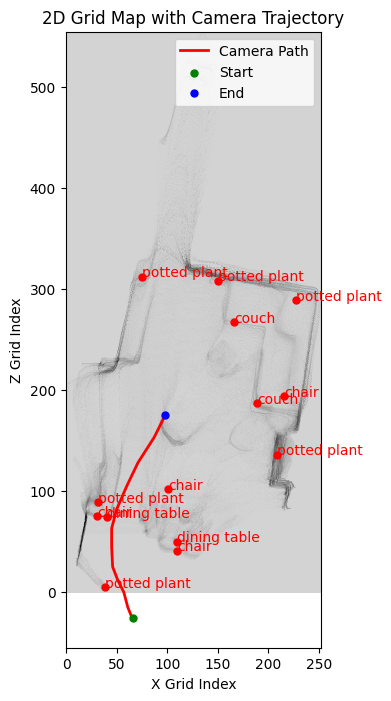

In [536]:
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

# add real world point
for annotation in annotations:
  # if annotation["avg_confidence"] < 0.25:
  #   continue
  plt.scatter(annotation["grid_point"][0], annotation["grid_point"][1], color='red', s=25)
  plt.text(annotation["grid_point"][0], annotation["grid_point"][1], annotation["class"], color='red', fontsize=10)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()